# Multi-Agent System Evaluation for Financial Analysis

## Overview
This is a multi-agent financial analysis system built with LangGraph that intelligently routes user queries between internal proprietary research and external web search.

## How It Works

The agent uses a **routing-based architecture** to determine the best information source:

- **Internal Research Route (RAG)**: When users ask about "our research", "proprietary analysis", or "internal findings"
- **External Search Route (Tavily)**: For general market questions, current stock prices, or public information

## Key Components

### 1. Router Node
- Analyzes incoming queries for internal research keywords
- Routes to either RAG pipeline or Tavily search

### 2. RAG Pipeline
- **Retrieval**: Searches internal PDF documents (AMD and NVIDIA analysis)
- **Quality Check**: Evaluates if retrieved docs can answer the query
- **Generation**: Creates response based on internal research
- **Fallback**: Falls back to Tavily if internal docs insufficient

### 3. Tavily Search
- Performs web search for external information
- Generates responses based on current market data

## Data Sources
- **Internal**: AMD and NVIDIA proprietary analysis PDFs
- **External**: Web search via Tavily API

## Response Format
- Maximum 3 sentences per response
- Clear attribution of information sources
- Honest acknowledgment when information isn't available

In [ ]:
!pip install -U langsmith langchain-openai langchain-community openai openevals PyMuPDF langchain-tavily langgraph

In [1]:
import os
import getpass

# Set up environment variables with your input
print("Please enter your API keys to get started:")
print("=" * 50)

# LangSmith tracing setting
langsmith_tracing = input("Enable LangSmith tracing? (true/false) [default: true]: ").strip() or "true"
os.environ["LANGSMITH_TRACING"] = langsmith_tracing

# LangSmith API key (secure input)
if not os.getenv("LANGSMITH_API_KEY"):
    langsmith_api_key = getpass.getpass("Enter your LangSmith API key: ")
    os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
else:
    print("✓ LangSmith API key already set")

# OpenAI API key (secure input)
if not os.getenv("OPENAI_API_KEY"):
    openai_api_key = getpass.getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = openai_api_key
else:
    print("✓ OpenAI API key already set")

# Tavily API key (secure input)
if not os.getenv("TAVILY_API_KEY"):
    tavily_api_key = getpass.getpass("Enter your Tavily API key: ")
    os.environ["TAVILY_API_KEY"] = tavily_api_key
else:
    print("✓ Tavily API key already set")

print("\n✓ Environment setup complete!")
print("You can now proceed with the rest of the notebook.")

Please enter your API keys to get started:

✓ Environment setup complete!
You can now proceed with the rest of the notebook.


In [22]:
import os
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
import operator
from langsmith import Client
from typing import TypedDict, Annotated
import asyncio

In [3]:
# Define the state structure
class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    query: str
    retrieved_docs: str
    has_sufficient_info: bool
    response: str

# Initialize models and tools
llm = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)
embeddings = OpenAIEmbeddings()
tavily_search = TavilySearch(max_results=3)

In [ ]:
# List of PDF files to load
pdf_files = [
    "/content/AMD_INTERNAL_ANALYSIS_20250724.pdf",
    "/content/NVIDIA_INTERNAL_ANALYSIS_20250724.pdf"
]

# Load documents from the URLs
docs = [PyMuPDFLoader(pdf_file).load() for pdf_file in pdf_files]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)

# With langchain we can easily turn any vector store into a retrieval component:
retriever = vectorstore.as_retriever(k=4)

In [5]:
# Router Node
def router_node(state: GraphState) -> GraphState:
    """Route to RAG if query mentions internal research, otherwise to Tavily"""
    query = state["query"]
    
    # Check if query is about internal research
    internal_keywords = ["internal research", "our research", "proprietary", "our study", 
                        "our analysis", "internal study", "our findings", "our team"]
    
    query_lower = query.lower()
    is_internal = any(keyword in query_lower for keyword in internal_keywords)
    
    # Route decision
    route = "RAG" if is_internal else "TAVILY"
    
    state["messages"].append({"role": "system", "content": f"Routing to: {route}"})
    
    return state

In [15]:
# RAG Retrieval Node
def rag_retrieval_node(state: GraphState) -> GraphState:
    """Retrieve relevant documents from internal research"""
    query = state["query"]
    
    # Retrieve relevant documents
    relevant_docs = retriever.invoke(query)
    
    # Format retrieved content
    if relevant_docs:
        retrieved_content = "\n\n".join([doc.page_content for doc in relevant_docs])
        state["retrieved_docs"] = retrieved_content
    else:
        state["retrieved_docs"] = ""
    
    return state

In [7]:
# RAG Quality Check Node
def rag_check_node(state: GraphState) -> GraphState:
    """Check if retrieved documents have sufficient information"""
    query = state["query"]
    retrieved_docs = state["retrieved_docs"]
    
    if not retrieved_docs:
        state["has_sufficient_info"] = False
        return state
    
    # Ask LLM to evaluate if retrieved docs can answer the query
    check_prompt = f"""
    Query: {query}
    
    Retrieved Information:
    {retrieved_docs}
    
    Can the retrieved information sufficiently answer the user's query? 
    Respond with only 'YES' or 'NO'.
    """
    
    response = llm.invoke(check_prompt)
    state["has_sufficient_info"] = "YES" in response.content.upper()
    
    return state

In [8]:
# RAG Generation Node
def rag_generation_node(state: GraphState) -> GraphState:
    """Generate response based on retrieved documents"""
    query = state["query"]
    retrieved_docs = state["retrieved_docs"]
    
    generation_prompt = f"""
    Based on our internal research, answer the following query:
    
    Internal Research Data:
    {retrieved_docs}
    
    User Query: {query}
    
    Provide a comprehensive answer based on the internal research provided. If you don't see the answer in the internal research, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    
    response = llm.invoke(generation_prompt)
    state["response"] = response.content
    
    return state

In [ ]:
def tavily_search_node(state: GraphState) -> GraphState:
    """Search the web using Tavily and generate response"""
    query = state["query"]
    
    # Perform web search
    search_results = tavily_search.invoke({"query": query})
    
    if not search_results:
        state["response"] = "No search results found."
        return state

    formatted_results = []
    # Handle the actual structure of Tavily results - access the 'results' key
    results_list = search_results.get('results', []) if isinstance(search_results, dict) else []
    for result in results_list[:3]:
        formatted_results.append(f"- {result.get('content', '')}")
        
    # Generate response based on search results
    search_prompt = f"""
    Based on the following web search results, answer the user's query:
    
    Search Results:
    {formatted_results}
    
    User Query: {query}
    
    Provide an answer based on the search results. If you don't see the answer in the search results, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    
    response = llm.invoke(search_prompt)
    state["response"] = response.content
    
    return state

In [16]:
# Build the graph
def create_agent():
    """Create the LangGraph workflow"""
    graph_builder = StateGraph(GraphState)
    
    # Add nodes
    graph_builder.add_node("router", router_node)
    graph_builder.add_node("rag_retrieval", rag_retrieval_node)
    graph_builder.add_node("rag_check", rag_check_node)
    graph_builder.add_node("rag_generation", rag_generation_node)
    graph_builder.add_node("tavily_search", tavily_search_node)
    
    # Set entry point
    graph_builder.set_entry_point("router")
    
    # Add routing from router node
    def route_query(state):
        query_lower = state["query"].lower()
        internal_keywords = ["internal research", "our research", "proprietary", "our study", 
                            "our analysis", "internal study", "our findings", "our team"]
        
        if any(keyword in query_lower for keyword in internal_keywords):
            return "rag"
        return "tavily"
    
    graph_builder.add_conditional_edges(
        "router",
        route_query,
        {
            "rag": "rag_retrieval",
            "tavily": "tavily_search"
        }
    )
    
    # RAG flow
    graph_builder.add_edge("rag_retrieval", "rag_check")
    
    # Conditional routing from RAG check
    graph_builder.add_conditional_edges(
        "rag_check",
        lambda state: "generate" if state["has_sufficient_info"] else "tavily",
        {
            "generate": "rag_generation",
            "tavily": "tavily_search"
        }
    )
    
    # End states
    graph_builder.add_edge("rag_generation", END)
    graph_builder.add_edge("tavily_search", END)
    
    # Compile the graph
    return graph_builder.compile()


In [18]:
app = create_agent()

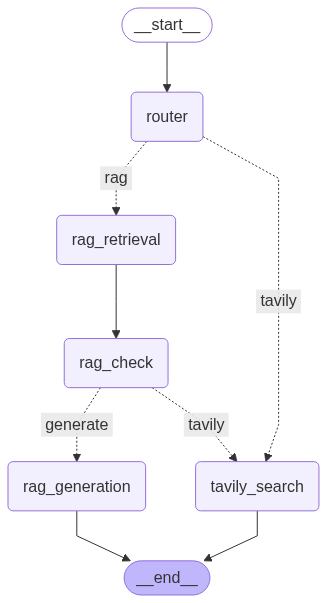

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
# Simple execution function
def run_agent(query: str):
    """Execute the agent with a query"""
    
    # Initialize state
    initial_state = {
        "messages": [],
        "query": query,
        "retrieved_docs": "",
        "has_sufficient_info": False,
        "response": ""
    }
    
    # Run the graph
    result = app.invoke(initial_state)
    
    return result["response"]

In [ ]:

# Test queries
test_queries = [
    "What is NVIDIA's next generation GPU?"
]

for query in test_queries:
    print(f"\nQuery: {query}")
    print("-" * 50)
    response = run_agent(query)
    print(f"Response: {response}")
    print("=" * 80)
    


Query: From our internal research, what is NVIDIA's next generation GPU?
--------------------------------------------------
Response: NVIDIA's next-generation GPU is the GeForce RTX 50 Series, designed for gamers, creators, and developers. It features advanced hardware and AI technologies, including the NVIDIA RTX Kit and RTX Neural Shaders SDK. These innovations enable improved ray tracing, neural rendering, and AI model performance.


# Multi-Agent System Evaluation for Financial Analysis

## Why Evaluate Agents?

Multi-agent systems have multiple potential points of failure. Systematic evaluation helps us:
- **Identify weaknesses** in specific components
- **Measure performance** objectively across different scenarios  
- **Track improvements** as we iterate on the system
- **Build confidence** in production deployment

## Our Evaluation Strategy

We implement **two complementary evaluation approaches** that test different aspects of the agent:

### 1. Intent Routing Evaluation (Single Step)
**What it tests**: Does the router correctly identify when to use internal research vs. external search?

**Why it matters**: Incorrect routing leads to:
- Proprietary questions answered with public information
- General questions unnecessarily constrained to internal docs
- Poor user experience and potentially wrong answers

**How it works**: 
- Test queries with various phrasings of internal research requests
- Measure accuracy of RAG vs. Tavily routing decisions
- Focus on edge cases and ambiguous queries

### 2. Final Response Evaluation (End-to-End)
**What it tests**: Is the final answer accurate?

**Why it matters**: Even with correct routing, the agent might:
- Hallucinate information not in the source documents
- Fail to properly attribute internal vs. external information
- Provide responses that are too vague or off-topic

**How it works**:
- LLM-as-judge evaluation comparing agent responses to ground truth
- Tests the complete pipeline from query → routing → retrieval → generation
- Evaluates factual accuracy, source attribution, and overall quality

In [ ]:
client = Client()

# Create dataset for intent routing evaluation
intent_examples = [
    {
        "inputs": {"query": "What did our analysts produce for AMD's latest performance?"},
        "outputs": {"route": "rag"},
    },
    {
        "inputs": {"query": "What does our research say about near term catalysts for NVIDIA?"},
        "outputs": {"route": "rag"},
    },
    {
        "inputs": {"query": "What is the latest market news for NVIDIA GPUs?"},
        "outputs": {"route": "tavily"},
    },
    {
        "inputs": {"query": "How is AMD stock performing today?"},
        "outputs": {"route": "tavily"},
    },
]

dataset_name_intent = "Financial Agent: Intent Routing"
if not client.has_dataset(dataset_name=dataset_name_intent):
    dataset = client.create_dataset(dataset_name=dataset_name_intent)
    client.create_examples(
        dataset_id=dataset.id,
        examples=intent_examples
    )

# Intent routing evaluator
def correct_route(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the agent chose the correct route."""
    return outputs["route"] == reference_outputs["route"]

# Target function for intent routing evaluation
def run_intent_classifier(inputs: dict) -> dict:
    """Run just the routing logic and return the route decision."""
    query = inputs["query"]
    query_lower = query.lower()
    internal_keywords = ["internal research", "our research", "proprietary", "our study",
                        "our analysis", "internal study", "our findings", "our team"]
    
    # Determine route based on keywords
    route = "rag" if any(keyword in query_lower for keyword in internal_keywords) else "tavily"
    
    return {"route": route}

In [ ]:

# Create dataset for final response evaluation
final_response_examples = [
    {
        "inputs": {
            "query": "What does our research say about near term catalysts for NVIDIA?",
        },
        "outputs": {
            "response": "Based on our internal research, NVIDIA's near-term growth will be driven by the production ramp of its new Blackwell architecture chips (B100 and B200) and the resumption of H20 export licenses for the China market. The company is positioned to benefit from the industry's transition from AI training to inference deployment, along with increased enterprise adoption of its AI software platform. Additional momentum should come from sovereign AI initiatives as nations invest in building their own domestic AI infrastructure capabilities.",
        }
    },
    {
        "inputs": {
            "query": "What is the latest market news for NVIDIA GPUs?",
        },
        "outputs": {
            "response": "Strong Demand & Market Dominance: Nvidia continues to be the overwhelming leader in the AI chip market, with its GPUs powering numerous AI applications and data centers. Demand for Nvidia's next-generation Blackwell platform is strong, driven by the increasing complexity of AI models and the emergence of reasoning-based applications.",
        }
    },
]

dataset_name_final = "Financial Agent: Final Response"
if not client.has_dataset(dataset_name=dataset_name_final):
    dataset = client.create_dataset(dataset_name=dataset_name_final)
    client.create_examples(
        dataset_id=dataset.id,
        examples=final_response_examples
    )

# LLM-as-judge evaluator for final responses
grader_instructions = """You are evaluating a financial analysis agent's responses.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the AGENT RESPONSE.

Grade the agent response based on:
1. Factual accuracy relative to the ground truth
2. Appropriateness for a financial analysis context
3. Whether it correctly indicates if information comes from internal research vs external sources
4. Overall helpfulness and relevance

The agent response doesn't need to match exactly, but should be factually consistent and appropriately sourced.

Explain your reasoning step-by-step."""

class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the agent response is mostly or exactly correct, otherwise False."]

# Initialize grader LLM
grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(Grade, method="json_schema", strict=True)

def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    
    user = f"""QUESTION: {inputs['query']}
GROUND TRUTH RESPONSE: {reference_outputs['response']}
AGENT RESPONSE: {outputs['response']}"""

    grade = grader_llm.invoke([
        {"role": "system", "content": grader_instructions}, 
        {"role": "user", "content": user}
    ])
    return grade["is_correct"]

# Target function for final response evaluation
def run_full_agent(inputs: dict) -> dict:
    """Run the full agent and return the final response."""
    query = inputs["query"]
    
    # Use your existing run_agent function
    response = run_agent(query)
    return {"response": response}

In [33]:
def run_evaluations():
    """Run both types of evaluations."""
    
    print("Running Intent Routing Evaluation...")
    intent_results = client.evaluate(
        run_intent_classifier,
        data=dataset_name_intent,
        evaluators=[correct_route],
        experiment_prefix="financial-agent-intent-routing",
        max_concurrency=4,
    )
    
    print("Intent Routing Results:")
    print(intent_results.to_pandas())
    
    print("\nRunning Final Response Evaluation...")
    final_results = client.evaluate(
        run_full_agent,
        data=dataset_name_final,
        evaluators=[final_answer_correct],
        experiment_prefix="financial-agent-final-response",
        num_repetitions=1,
        max_concurrency=4,
    )
    
    print("Final Response Results:")
    print(final_results.to_pandas())
    
    return intent_results, final_results

In [34]:
intent_results, final_results = run_evaluations()

Running Intent Routing Evaluation...
View the evaluation results for experiment: 'financial-agent-intent-routing-653bfb0a' at:
https://smith.langchain.com/o/b8c00c25-9820-5aa4-a030-cfcde0aef6cf/datasets/fb90ee3e-4a29-49df-b8b9-db4a7e68b1ec/compare?selectedSessions=0629a022-6216-4036-b9ed-41a7a8ae9748




0it [00:00, ?it/s]

Intent Routing Results:
                                        inputs.query outputs.route error  \
0                 How is AMD stock performing today?        tavily  None   
1  What does our research say about near term cat...           rag  None   
2  What did our analysts produce for AMD's latest...        tavily  None   
3    What is the latest market news for NVIDIA GPUs?        tavily  None   

  reference.route  feedback.correct_route  execution_time  \
0          tavily                    True        0.000620   
1             rag                    True        0.001136   
2             rag                   False        0.000805   
3          tavily                    True        0.000771   

                             example_id                                    id  
0  6fac6489-3dfe-4c43-86b4-b262dd73c32b  7e43e25d-4c85-4fcd-b4d7-377f3494f023  
1  8af94d67-f047-4a16-a523-7a5fa7d21b22  c716a160-ca36-4eed-8885-714cf0908ab3  
2  bc9b6a48-0ba7-4871-99b8-df8e7bde5804  23918fef

0it [00:00, ?it/s]

Final Response Results:
                                        inputs.query  \
0  What does our research say about near term cat...   
1    What is the latest market news for NVIDIA GPUs?   

                                    outputs.response error  \
0  Our internal research identifies several near-...  None   
1  The latest market news indicates strong demand...  None   

                                  reference.response  \
0  Based on our internal research, NVIDIA's near-...   
1  Strong Demand & Market Dominance: Nvidia conti...   

   feedback.final_answer_correct  execution_time  \
0                           True        2.835561   
1                          False        2.941764   

                             example_id                                    id  
0  90d192b5-ca1e-4ccd-aff9-f84b1921a9b2  7a0072af-a970-4138-b4ec-15fbe19b4190  
1  5beafde0-b7b0-41ba-8a28-f300952a53fe  744b7856-4069-485e-8601-663b9eb19dc8  
